# Sidekick - Multi-Pojects Predictions
Scratch work to perform predictions for a project by considering multiple projects.

In [1]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import GPy
import cPickle as cp
import matplotlib.pyplot as plt
from math import floor
from dataset import Sidekick
from misc_utils import progress

DATA_DIR = "../data/kickstarter-etter-cosn2013"

warning in stationary: failed to import cython module: falling back to numpy


## Load data

In [2]:
sk = Sidekick()
sk.load()

Loading projects...
Loading statuses...
Converting to project instances...
Data loaded.


## Prepare data
Keep `T`% of the projects for training and `(100-T)`% for testing.

In [12]:
projects = sk.data[:10]
num_observations = 1000
T = 0.8

threshold = int(floor(T * len(projects)))
projects_train = projects[:threshold]
projects_test = projects[threshold:]
X_train = np.ndarray(shape=(num_observations, 1), buffer=np.arange(num_observations), dtype=int)
Y_train = np.array([project.money for project in projects]).T
print X_train.shape, Y_train.shape

(1000, 1) (1000, 100)


## Train model
Train a GP with a given kernel.

In [13]:
kernel = GPy.kern.RBF(input_dim=1)
m = GPy.models.GPRegression(X_train, Y_train, kernel)
#m.optimize_restarts(num_restarts=10)
m.optimize()
display(m)

GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,0.901305989375,+ve,,
rbf.lengthscale,12.592851517,+ve,,
Gaussian_noise.variance,5.38723481161e-05,+ve,,


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x137f36510>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x137b76fd0>],
  [<matplotlib.lines.Line2D at 0x137d63310>]]}

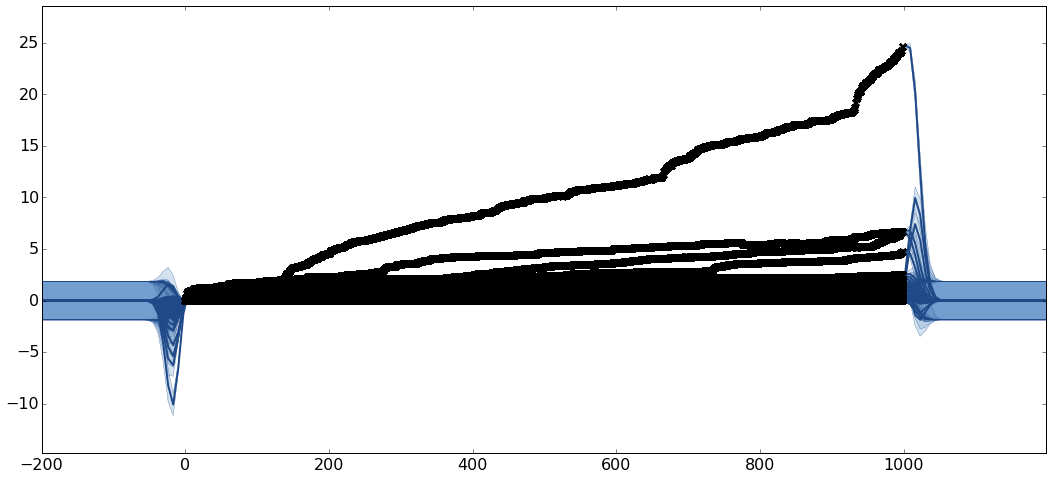

In [14]:
m.plot()

## Test unseen project
We observe 80% of the project pledged money and we predict then the last point, that is the total amount of money pledged at the end of the project. If it is greater than 1, then the project has been funded.

In [15]:
new_project = projects_test[6]
proportion = 0.8
last_observation = 999

goal = new_project['project'][1]
observe = int(floor(num_observations * proportion))

X_observation = np.ndarray(shape=(observe, 1), buffer=np.arange(observe), dtype=int) 
Y_observation = np.ndarray(shape=(observe, 1), buffer=np.array([status[1] for status in new_project['status'][:observe]]), dtype=float) 
m.set_XY(X=X_observation, Y=Y_observation)
mean, var = m.predict(np.ndarray((1,1), buffer=np.array(last_observation), dtype=int))
predicted_pledged = mean[0][0]
predicted_var = var[0][0]
actual_pledged = new_project['status'][last_observation][1]
print "Goal: %s" % goal
print "Predicted success: %s (%.2f±%.2f)" % (str(predicted_pledged > 1), predicted_pledged, np.sqrt(predicted_var))
print "Actual success: %s (%.2f)" % (str(actual_pledged > 1), actual_pledged)

Goal: 5000
Predicted success: False (0.00±2.10)
Actual success: True (1.03)


## Evaluation
Run an evaluation on the full test set.

In [21]:
def evaluate_project(project):
    last_observation = 999
    goal = project['project'][1]
    correct = []
    for p in np.linspace(0.01, 0.99, 20):
        # Set the number of observed data
        observe = int(floor(num_observations * p))
        # Set the new observation in the model without modifying it
        X_observation = np.ndarray(shape=(observe, 1), buffer=np.arange(observe), dtype=int) 
        Y_observation = np.ndarray(shape=(observe, 1), buffer=np.array([status[1] for status in new_project['status'][:observe]]), dtype=float) 
        m.set_XY(X=X_observation, Y=Y_observation)
        # Predict the end of the project
        mean, var = m.predict(np.ndarray((1,1), buffer=np.array(last_observation), dtype=int))
        predicted_pledged = mean[0][0]
        predicted_success = predicted_pledged > 1
        predicted_var = var[0][0]
        actual_pledged = new_project['status'][last_observation][1]
        actual_success = actual_pledged > 1
        correct.append(predicted_pledged == actual_success)
    return correct

result = []
total = len(projects_test)
for i, project in enumerate(projects_test):
    progress(i, total)
    result.append(evaluate_project(project))

20
 0.00% 5.26% (50s remaining)10.53% (47s remaining)15.79% (44s remaining)21.05% (41s remaining)26.32% (38s remaining)31.58% (36s remaining)36.84% (33s remaining)42.11% (31s remaining)47.37% (28s remaining)52.63% (26s remaining)57.89% (23s remaining)63.16% (20s remaining)68.42% (18s remaining)73.68% (15s remaining)78.95% (13s remaining)84.21% (10s remaining)89.47% (7s remaining) 94.74% (5s remaining) 100.00% (2s remaining)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


## Plot result
Plot the accuracy versus relative time together with error bars.

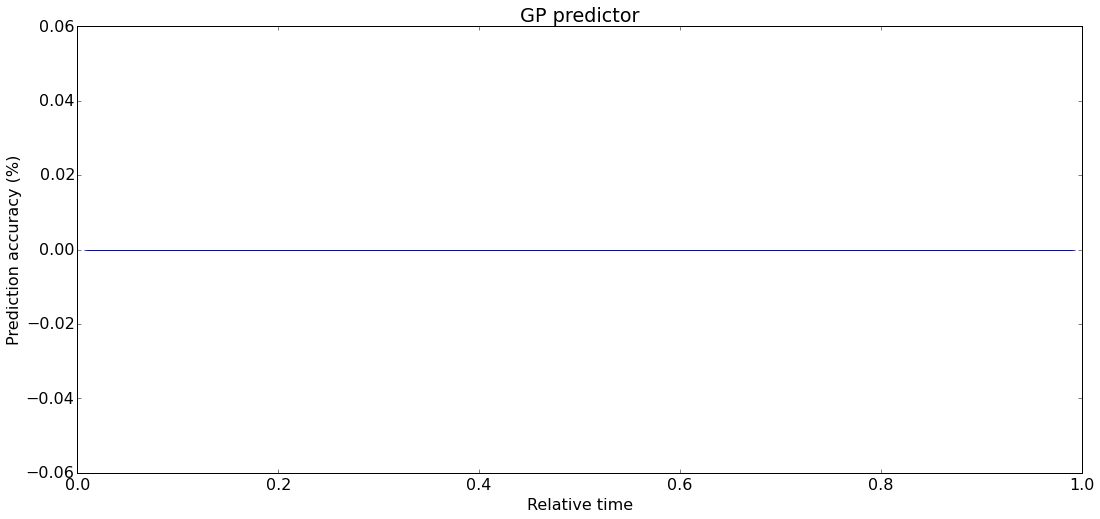

In [28]:
r = np.array(result)
plt.errorbar(np.linspace(0.01, 0.99, 20), 100 * np.mean(r, axis=0), 100 * np.std(r, axis=0))
plt.title("GP predictor")
plt.ylabel("Prediction accuracy (%)")
plt.xlabel("Relative time")
plt.show()